# Content-based recommender system

## Europe Top 10 Attractions

### This notebook uses the EuropeTop100Attractions_ENG_20190101_20210821 dataset
Content-based recommendations systems recommend atractions that are similar to atractions previously visited by other customers. The models used in content-based recommender systems identify common features across user preferences based on the historical choices data of the user.

Develop a system to recommend attractions that similar users visited. For example, based on previous visits from all users, recommend an attraction to go together with a another attraction.


In [1]:
# Packages
import os
import numpy as np
import pandas as pd
import openpyxl
import re
from sklearn.metrics import pairwise 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Distances functions
from sklearn.metrics import pairwise_distances

In [3]:
# Global definitions
baseFolder = os.getcwd()
exportsFolder = baseFolder + os.sep +'Exports' + os.sep

In [4]:
subPlots_Title_fontSize = 12
subPlots_xAxis_fontSize = 10
subPlots_yAxis_fontSize = 10
subPlots_label_fontSize = 10
heatmaps_text_fontSize = 8

plots_Title_fontSize = 14
plots_Title_textColour = 'black'

plots_Legend_fontSize = 12
plots_Legend_textColour = 'black'

In [5]:
# Load data 
ds = pd.read_excel('EuropeTop100Attractions_ENG_20190101_20210821.xlsx', engine='openpyxl')
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92120 entries, 0 to 92119
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   localID            92120 non-null  object        
 1   extractionDate     92120 non-null  datetime64[ns]
 2   globalRating       92120 non-null  float64       
 3   positionOnRanking  92120 non-null  int64         
 4   sitesOnRanking     92120 non-null  int64         
 5   totalReviews       92120 non-null  int64         
 6   userName           92120 non-null  object        
 7   userLocation       78652 non-null  object        
 8   userContributions  92120 non-null  int64         
 9   tripType           63052 non-null  object        
 10  reviewWritten      92120 non-null  datetime64[ns]
 11  reviewVisited      91410 non-null  datetime64[ns]
 12  reviewRating       92120 non-null  int64         
 13  reviewLanguage     92120 non-null  object        
 14  review

In [6]:
# Reformat variable types
cols = ['localID','userName','userLocation','tripType','reviewLanguage','reviewFullText']
ds[cols] = ds[cols].astype(str)

In [7]:
# Summary statistics for all variables
ds.describe(include='all', datetime_is_numeric=True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
localID,92120,100,MAG001,8309,NaN,NaN,NaN,NaN,NaN,NaN,NaN
extractionDate,92120,NaN,NaN,NaN,2021-08-20 22:09:20.598932992,2021-08-20 08:24:40.077000,2021-08-20 12:08:10.831000064,2021-08-20 15:46:58.171000064,2021-08-21 12:35:39.817250048,2021-08-21 16:27:17.026000,NaN
globalRating,92120.0,NaN,NaN,NaN,4.485166,4.0,4.5,4.5,4.5,5.0,0.178085
positionOnRanking,92120.0,NaN,NaN,NaN,3.91459,1.0,1.0,2.0,6.0,55.0,4.843013
sitesOnRanking,92120.0,NaN,NaN,NaN,748.263537,5.0,154.0,484.0,1186.0,3837.0,802.742304
totalReviews,92120.0,NaN,NaN,NaN,40556.601813,5179.0,14152.0,24454.0,51324.0,163828.0,42914.381014
userName,92120,65786,Malgorzata@Margo7850p,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userLocation,92120,12614,nan,13468,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userContributions,92120.0,NaN,NaN,NaN,477.52056,0.0,20.0,66.0,215.0,607732.0,7270.518677
tripType,92120,6,Couples,31702,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Check products cardinality
usernameCount = ds['userName'].value_counts()
usernameCount

Malgorzata@Margo7850p                    31
KodoDrummer@KodoDrummer                  24
None                                     20
Michele Amico🇮🇹🇮🇹🇮🇹🇮🇹@micheleaQ8239JH    19
Dimitris L@750dimitrisl                  17
                                         ..
Mogoshadi S@mogoshadis                    1
Crystal Chris@CrystalPistol007            1
Grantley@GrantleyMorgan                   1
Burnsfun@Burnsfun                         1
czlido@czlido                             1
Name: userName, Length: 65786, dtype: int64

In [9]:
# Check products cardinality
userlocationCount = ds['userLocation'].value_counts()
userlocationCount

nan                        13468
London, UK                  3710
Melbourne, Australia         773
Sydney, Australia            736
New York City, NY            699
                           ...  
Teresopolis, RJ                1
Pittsworth, Australia          1
Scone, Australia               1
Berea, OH                      1
Elburg, The Netherlands        1
Name: userLocation, Length: 12614, dtype: int64

In [10]:
# Check products cardinality
tripTypeCount = ds['tripType'].value_counts()
tripTypeCount

Couples     31702
nan         29068
Family      13596
Friends     11759
Solo         5127
Business      868
Name: tripType, dtype: int64

## Data Preparation

In [11]:
#identify duplicate rows
duplicateRows = ds[ds.duplicated()]

In [12]:
#view duplicate rows
duplicateRows

,localID,extractionDate,globalRating,positionOnRanking,sitesOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,reviewLanguage,reviewFullText


In [13]:
## figuring out if we can remove the outliers
ds['positionOnRanking'].value_counts()

1     38547
2     12821
3     11549
7      7026
8      5668
11     2885
4      2834
10     2362
6      2282
5      2223
12     1097
24      806
9       710
31      595
16      312
19      243
55      160
Name: positionOnRanking, dtype: int64

In [14]:
# removing rows from position on ranking 
ds =ds[ds['positionOnRanking']<=12]

In [15]:
ds['positionOnRanking'].value_counts()

1     38547
2     12821
3     11549
7      7026
8      5668
11     2885
4      2834
10     2362
6      2282
5      2223
12     1097
9       710
Name: positionOnRanking, dtype: int64

In [16]:
# checking for missing data,  creating bool series for missing data
bool_series = pd.isnull(ds['userLocation'])

In [17]:
# filtering data
# displaying data only with location = NaN
ds[bool_series]

,localID,extractionDate,globalRating,positionOnRanking,sitesOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,reviewLanguage,reviewFullText


In [18]:
#Use the modal value to replace missing data in userLocation
ds['userLocation'].replace([np.nan], ds['userLocation'].mode()[0], inplace=True)
print(ds)

      localID          extractionDate  globalRating  positionOnRanking  \
0      MAG001 2021-08-20 08:24:40.077           4.5                  1   
1      MAG001 2021-08-20 08:24:40.097           4.5                  1   
2      MAG001 2021-08-20 08:24:40.117           4.5                  1   
3      MAG001 2021-08-20 08:24:40.147           4.5                  1   
4      MAG001 2021-08-20 08:24:40.159           4.5                  1   
...       ...                     ...           ...                ...   
92115  MAG100 2021-08-21 16:27:11.795           4.5                 11   
92116  MAG100 2021-08-21 16:27:11.893           4.5                 11   
92117  MAG100 2021-08-21 16:27:11.993           4.5                 11   
92118  MAG100 2021-08-21 16:27:12.086           4.5                 11   
92119  MAG100 2021-08-21 16:27:17.026           4.5                 11   

       sitesOnRanking  totalReviews                   userName  \
0                1186        163828      Maur

In [19]:
# display data where location previously = NaN
ds[bool_series]

,localID,extractionDate,globalRating,positionOnRanking,sitesOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,reviewLanguage,reviewFullText


In [20]:
# checking for missing data review visited,  creating bool series for missing data
dv_series = pd.isnull(ds['reviewVisited'])

In [21]:
ds[dv_series]

,localID,extractionDate,globalRating,positionOnRanking,sitesOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,reviewLanguage,reviewFullText
78,MAG001,2021-08-20 08:25:18.941,4.5,1,1186,163828,thomas@thomasphunos,"Manchester, UK",1,nan,2020-09-25,NaT,4,en,"Amazing place , now a days it was not very qui..."
624,MAG001,2021-08-20 08:30:40.273,4.5,1,1186,163828,Paolo616616@Paolo616616,"Prague, Czech Republic",284,nan,2020-02-03,NaT,5,en,"Beautiful unfinished building, should be compl..."
841,MAG001,2021-08-20 08:33:01.027,4.5,1,1186,163828,StevenK@stevenkoh9999,"Singapore, Singapore",172,nan,2020-01-08,NaT,5,en,A lifetime of designing and planning by the ar...
850,MAG001,2021-08-20 08:33:06.518,4.5,1,1186,163828,Margarita@Margaritano,Europe,18,nan,2020-01-07,NaT,4,en,Everybody suggest Sagrada Familia. I loved the...
3183,MAG001,2021-08-20 08:55:30.759,4.5,1,1186,163828,Andrew Jones@wigan1969,nan,2,nan,2019-09-05,NaT,1,en,"Nice to look at from the outside, however I ha..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89332,MAG087,2021-08-21 15:58:48.146,4.0,1,5,6182,Jo P@I4996RBjoannap,"Brough, UK",343,nan,2019-07-31,NaT,5,en,Plenty to walk around and see and you can walk...
89338,MAG087,2021-08-21 15:58:48.682,4.0,1,5,6182,GMcC73@GMcC73,"Cork, Ireland",36,nan,2019-07-28,NaT,4,en,We spent a really enjoyable 4 hours there with...
89339,MAG087,2021-08-21 15:58:48.774,4.0,1,5,6182,CWXXXJH@CWXXXJH,"Berkhamsted, UK",46,nan,2019-07-22,NaT,5,en,Well worth signing up for one of the twice dai...
89347,MAG087,2021-08-21 15:58:54.396,4.0,1,5,6182,Lala L@LalaL827,"Alrewas, UK",87,nan,2019-07-10,NaT,3,en,"I cycled here in the morning, came off the mai..."


In [22]:
#Use the modal value to replace missing data in reviewvisited
ds['reviewVisited'].replace([np.nan], ds['reviewVisited'].mode()[0], inplace=True)

In [23]:
ds[dv_series]

,localID,extractionDate,globalRating,positionOnRanking,sitesOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,reviewLanguage,reviewFullText
78,MAG001,2021-08-20 08:25:18.941,4.5,1,1186,163828,thomas@thomasphunos,"Manchester, UK",1,nan,2020-09-25,2019-09-01,4,en,"Amazing place , now a days it was not very qui..."
624,MAG001,2021-08-20 08:30:40.273,4.5,1,1186,163828,Paolo616616@Paolo616616,"Prague, Czech Republic",284,nan,2020-02-03,2019-09-01,5,en,"Beautiful unfinished building, should be compl..."
841,MAG001,2021-08-20 08:33:01.027,4.5,1,1186,163828,StevenK@stevenkoh9999,"Singapore, Singapore",172,nan,2020-01-08,2019-09-01,5,en,A lifetime of designing and planning by the ar...
850,MAG001,2021-08-20 08:33:06.518,4.5,1,1186,163828,Margarita@Margaritano,Europe,18,nan,2020-01-07,2019-09-01,4,en,Everybody suggest Sagrada Familia. I loved the...
3183,MAG001,2021-08-20 08:55:30.759,4.5,1,1186,163828,Andrew Jones@wigan1969,nan,2,nan,2019-09-05,2019-09-01,1,en,"Nice to look at from the outside, however I ha..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89332,MAG087,2021-08-21 15:58:48.146,4.0,1,5,6182,Jo P@I4996RBjoannap,"Brough, UK",343,nan,2019-07-31,2019-09-01,5,en,Plenty to walk around and see and you can walk...
89338,MAG087,2021-08-21 15:58:48.682,4.0,1,5,6182,GMcC73@GMcC73,"Cork, Ireland",36,nan,2019-07-28,2019-09-01,4,en,We spent a really enjoyable 4 hours there with...
89339,MAG087,2021-08-21 15:58:48.774,4.0,1,5,6182,CWXXXJH@CWXXXJH,"Berkhamsted, UK",46,nan,2019-07-22,2019-09-01,5,en,Well worth signing up for one of the twice dai...
89347,MAG087,2021-08-21 15:58:54.396,4.0,1,5,6182,Lala L@LalaL827,"Alrewas, UK",87,nan,2019-07-10,2019-09-01,3,en,"I cycled here in the morning, came off the mai..."


In [24]:
# checking for missing data for trip type,  creating bool series for missing data
tt_series = pd.isnull(ds['tripType'])

In [25]:
ds[tt_series]

,localID,extractionDate,globalRating,positionOnRanking,sitesOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,reviewLanguage,reviewFullText


In [26]:
#Use 'Other' value to replace missing data in triptype
ds['tripType'].fillna(value = 'Other', inplace = True)

In [27]:
ds[tt_series]

,localID,extractionDate,globalRating,positionOnRanking,sitesOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,reviewLanguage,reviewFullText


In [28]:
# Loading the Table Attraction and combine

In [29]:
ds_att = pd.read_excel(io = 'EuropeTop100Attractions_ENG_20190101_20210821.xlsx', sheet_name= 'Attractions',engine= 'openpyxl')
ds_att

,ID,Name,Country,ISO
0,MAG001,Basilica of the Sagrada Familia,Spain,ES
1,MAG002,Parc Guell,Spain,ES
2,MAG003,Tower of London,England,UK
3,MAG004,Casa Batllo,Spain,ES
4,MAG005,Staromestske namesti,Czech Republic,CZ
...,...,...,...,...
95,MAG096,Duomo di Pisa,Italy,IT
96,MAG097,La Lonja de la Seda,Spain,ES
97,MAG098,The Walls of Avila,Spain,ES
98,MAG099,Place Stanislas,France,FR


In [30]:
ds_att.columns

Index(['ID', 'Name', 'Country', 'ISO'], dtype='object')

In [31]:
ds_att.columns = ['localID', 'Name', 'Country', 'ISO']
ds_att.columns

Index(['localID', 'Name', 'Country', 'ISO'], dtype='object')

In [32]:
ds_com = ds.merge(ds_att, how='left', on='localID')
ds_com.head()

,localID,extractionDate,globalRating,positionOnRanking,sitesOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,reviewLanguage,reviewFullText,Name,Country,ISO
0,MAG001,2021-08-20 08:24:40.077,4.5,1,1186,163828,Maurice M@MauriceM171,"Indianapolis, IN",29,Couples,2021-08-18,2021-08-01,5,en,"Absolutely breathtaking use of light, an amazi...",Basilica of the Sagrada Familia,Spain,ES
1,MAG001,2021-08-20 08:24:40.097,4.5,1,1186,163828,nickchamb@nickchamb,"Bandon, Ireland",7,Couples,2021-08-17,2021-03-01,5,en,A really interesting and beautiful place to vi...,Basilica of the Sagrada Familia,Spain,ES
2,MAG001,2021-08-20 08:24:40.117,4.5,1,1186,163828,Arthur Villon@arthur4588,"Valencia, Spain",268,Friends,2021-08-16,2021-08-01,5,en,Beautiful place and must visit place in barcel...,Basilica of the Sagrada Familia,Spain,ES
3,MAG001,2021-08-20 08:24:40.147,4.5,1,1186,163828,James U@696jamesu,nan,7,nan,2021-08-16,2021-07-01,5,en,A MUST when visiting Barcelkona. It is consta...,Basilica of the Sagrada Familia,Spain,ES
4,MAG001,2021-08-20 08:24:40.159,4.5,1,1186,163828,Kamal K Sirra@Sirra63,"Madrid, Spain",516,Family,2021-08-15,2021-07-01,4,en,I visited about 20 years ago and there has bee...,Basilica of the Sagrada Familia,Spain,ES


In [33]:
# Reformat variable types
cols = ['Country']
ds_com[cols] = ds_com[cols].astype(str)

In [34]:
ds_com.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90004 entries, 0 to 90003
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   localID            90004 non-null  object        
 1   extractionDate     90004 non-null  datetime64[ns]
 2   globalRating       90004 non-null  float64       
 3   positionOnRanking  90004 non-null  int64         
 4   sitesOnRanking     90004 non-null  int64         
 5   totalReviews       90004 non-null  int64         
 6   userName           90004 non-null  object        
 7   userLocation       90004 non-null  object        
 8   userContributions  90004 non-null  int64         
 9   tripType           90004 non-null  object        
 10  reviewWritten      90004 non-null  datetime64[ns]
 11  reviewVisited      90004 non-null  datetime64[ns]
 12  reviewRating       90004 non-null  int64         
 13  reviewLanguage     90004 non-null  object        
 14  review

In [35]:
# Reformat variable types
cols = ['userName']
ds_com[cols] = ds_com[cols].astype(str)
ds_com.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90004 entries, 0 to 90003
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   localID            90004 non-null  object        
 1   extractionDate     90004 non-null  datetime64[ns]
 2   globalRating       90004 non-null  float64       
 3   positionOnRanking  90004 non-null  int64         
 4   sitesOnRanking     90004 non-null  int64         
 5   totalReviews       90004 non-null  int64         
 6   userName           90004 non-null  object        
 7   userLocation       90004 non-null  object        
 8   userContributions  90004 non-null  int64         
 9   tripType           90004 non-null  object        
 10  reviewWritten      90004 non-null  datetime64[ns]
 11  reviewVisited      90004 non-null  datetime64[ns]
 12  reviewRating       90004 non-null  int64         
 13  reviewLanguage     90004 non-null  object        
 14  review

In [36]:
df = pd.DataFrame(ds_com)
# drop rows that don't have a value of 5 in the "globalRating" column
df.drop(df[df['globalRating'] != 5].index, inplace=True)
df

,localID,extractionDate,globalRating,positionOnRanking,sitesOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,reviewLanguage,reviewFullText,Name,Country,ISO
38333,MAG015,2021-08-20 14:32:33.754,5.0,1,154,28236,Emil_London@Emil_London,"London, UK",27,Friends,2021-08-18,2021-08-01,5,en,"Absolutely amazing, a must see architectural m...",Mezquita Cathedral de Cordoba,Spain,ES
38334,MAG015,2021-08-20 14:32:33.799,5.0,1,154,28236,Davide G@766davideg,"Palermo, Italy",3176,nan,2021-08-18,2021-08-01,5,en,One of the best things on this planet. No pric...,Mezquita Cathedral de Cordoba,Spain,ES
38335,MAG015,2021-08-20 14:32:33.845,5.0,1,154,28236,Adventure262912@Adventure262912,nan,1,Couples,2021-08-14,2021-08-01,5,en,"Easy to book, the waiting line went really fas...",Mezquita Cathedral de Cordoba,Spain,ES
38336,MAG015,2021-08-20 14:32:33.885,5.0,1,154,28236,dustythoughts@dustythoughts,"Manchester, CT",1289,nan,2021-08-13,2020-09-01,5,en,The Mezquita-Catedral de Córdoba is a breathta...,Mezquita Cathedral de Cordoba,Spain,ES
38337,MAG015,2021-08-20 14:32:33.936,5.0,1,154,28236,qdupuy@qdupuy,"Amsterdam, The Netherlands",4,Couples,2021-08-13,2021-08-01,5,en,Very nice experience. Fast and easy access !We...,Mezquita Cathedral de Cordoba,Spain,ES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89948,MAG099,2021-08-21 16:26:33.652,5.0,1,73,5345,paul_w@paul_abcd_nl,"Holten, The Netherlands",129,Business,2019-03-03,2019-03-01,5,en,Nancy is a very nice city. Lot of restaurants...,Place Stanislas,France,FR
89949,MAG099,2021-08-21 16:26:33.768,5.0,1,73,5345,Aida H@45aidah,"Bamberg, Germany",31,Family,2019-02-13,2019-02-01,5,en,Absolutely the most beautiful place so far I v...,Place Stanislas,France,FR
89950,MAG099,2021-08-21 16:26:33.870,5.0,1,73,5345,Neil L@neill519,"Son en Breugel, The Netherlands",62,Friends,2019-02-10,2019-02-01,5,en,The square was excellent and was even better a...,Place Stanislas,France,FR
89951,MAG099,2021-08-21 16:26:33.990,5.0,1,73,5345,Thomas Ozbun@thomasozbun,"Vicenza, Italy",982,Couples,2019-02-01,2018-03-01,5,en,the main attraction of the city: Place Stanisl...,Place Stanislas,France,FR


In [37]:
df.describe(include='all',datetime_is_numeric=True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
localID,4517,10,MAG015,1050,NaN,NaN,NaN,NaN,NaN,NaN,NaN
extractionDate,4517,NaN,NaN,NaN,2021-08-21 04:15:29.456481792,2021-08-20 14:32:33.754000,2021-08-20 17:13:37.408000,2021-08-21 11:21:58.491000064,2021-08-21 13:13:37.550000128,2021-08-21 16:26:34.089000,NaN
globalRating,4517.0,NaN,NaN,NaN,5.0,5.0,5.0,5.0,5.0,5.0,0.0
positionOnRanking,4517.0,NaN,NaN,NaN,1.469559,1.0,1.0,1.0,1.0,9.0,1.833471
sitesOnRanking,4517.0,NaN,NaN,NaN,631.114235,46.0,108.0,153.0,154.0,2634.0,968.936188
totalReviews,4517.0,NaN,NaN,NaN,18214.52402,5345.0,13342.0,17581.0,21630.0,28236.0,6849.849484
userName,4517,4084,Michele Amico🇮🇹🇮🇹🇮🇹🇮🇹@micheleaQ8239JH,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userLocation,4517,1845,nan,524,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userContributions,4517.0,NaN,NaN,NaN,552.417755,1.0,27.0,96.0,315.0,146634.0,3884.894528
tripType,4517,6,Couples,1587,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
#Check Name Attraction cordinality
Nameattcount = df['Name'].value_counts()
Nameattcount

Mezquita Cathedral de Cordoba            1050
Church of the Savior on Spilled Blood     790
Historic Centre of Brugge                 789
Quinta da Regaleira                       595
Ancient City of Ephesus                   413
Historic Areas of Istanbul                251
Acueduct of Segovia                       246
Sassi di Matera                           210
Basilica Papale e Sacro Convento...       113
Place Stanislas                            60
Name: Name, dtype: int64

In [39]:
#Check Country Attraction cordinality
Countryattcount = df['Country'].value_counts()
Countryattcount

Spain       1296
Russia       790
Belgium      789
Turkey       664
Portugal     595
Italy        323
France        60
Name: Country, dtype: int64

In [40]:
### Customer-item matrix
NameattuserNameMatrix = df.pivot_table(
                    index='userName',
                    columns='Name',
                    values='reviewRating',
                    aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)

In [41]:
NameattuserNameMatrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4084 entries, 007JNR@007JNR to Рамиль Х@ramilk2013
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Acueduct of Segovia                    4084 non-null   float64
 1   Ancient City of Ephesus                4084 non-null   float64
 2   Basilica Papale e Sacro Convento...    4084 non-null   float64
 3   Church of the Savior on Spilled Blood  4084 non-null   float64
 4   Historic Areas of Istanbul             4084 non-null   float64
 5   Historic Centre of Brugge              4084 non-null   float64
 6   Mezquita Cathedral de Cordoba          4084 non-null   float64
 7   Place Stanislas                        4084 non-null   float64
 8   Quinta da Regaleira                    4084 non-null   float64
 9   Sassi di Matera                        4084 non-null   float64
dtypes: float64(10)
memory usage: 351.0+ KB


In [42]:
# See matrix for one specific attraction
NameattuserNameMatrix.head()

Name,Acueduct of Segovia,Ancient City of Ephesus,Basilica Papale e Sacro Convento...,Church of the Savior on Spilled Blood,Historic Areas of Istanbul,Historic Centre of Brugge,Mezquita Cathedral de Cordoba,Place Stanislas,Quinta da Regaleira,Sassi di Matera
userName,,,,,,,,,,
007JNR@007JNR,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
101ramirez@101ramirez,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1039@1039,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
112HermanK@112HermanK,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1171fc@1171fc,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


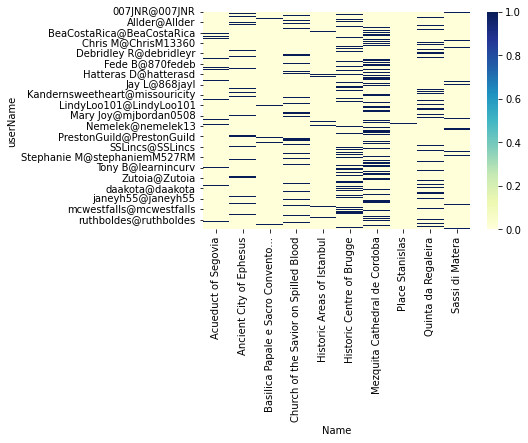

In [55]:
sns.heatmap(NameattuserNameMatrix, cmap='YlGnBu')
plt.show()

In [43]:
# Shape of the matrix
NameattuserNameMatrix.shape

(4084, 10)

## userName based recommendations
 ### Based on similar userNames' attractions visits

In [44]:
# Create a userName to userName similarity matrix
# Info on the "cosine" implementation https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.spatial.distance.cosine.html#scipy.spatial.distance.cosine
userName_userName_sim_matrix = pd.DataFrame(
    pairwise_distances(NameattuserNameMatrix,metric='cosine'),
    columns = NameattuserNameMatrix.index,
    index = NameattuserNameMatrix.index
)
userName_userName_sim_matrix = userName_userName_sim_matrix.apply(lambda x: 1-x, axis=1) # Transform dissimilarity to similarity
userName_userName_sim_matrix

userName,007JNR@007JNR,101ramirez@101ramirez,1039@1039,112HermanK@112HermanK,1171fc@1171fc,123susan456@123susan456,1247912@1247912,14DLB@14DLB,1527holiday1011@1527holiday1011,159terencej@159terencej,...,ynwafoodie@ynwafoodie,yrf2016@yrf2016,zaxmo@zaxmo,zoeh198@zoeh198,zuv@zuv,Μάρθα Μ@_T6960IQ,Екатерина Г@_C5261QZ,Иван@ivanishchenko,Катарина П@reddreamer,Рамиль Х@ramilk2013
userName,,,,,,,,,,,,,,,,,,,,,
007JNR@007JNR,1.0,1.0,0.000000,1.0,0.0,0.0,1.0,1.0,0.0,0.000000,...,1.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.000000,0.0,0.0
101ramirez@101ramirez,1.0,1.0,0.000000,1.0,0.0,0.0,1.0,1.0,0.0,0.000000,...,1.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.000000,0.0,0.0
1039@1039,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,...,0.0,0.707107,0.707107,0.0,0.0,0.0,0.0,0.707107,0.0,0.0
112HermanK@112HermanK,1.0,1.0,0.000000,1.0,0.0,0.0,1.0,1.0,0.0,0.000000,...,1.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.000000,0.0,0.0
1171fc@1171fc,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Μάρθα Μ@_T6960IQ,1.0,1.0,0.000000,1.0,0.0,0.0,1.0,1.0,0.0,0.000000,...,1.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.000000,0.0,0.0
Екатерина Г@_C5261QZ,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,...,0.0,0.000000,0.000000,1.0,0.0,0.0,1.0,0.000000,0.0,0.0
Иван@ivanishchenko,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0


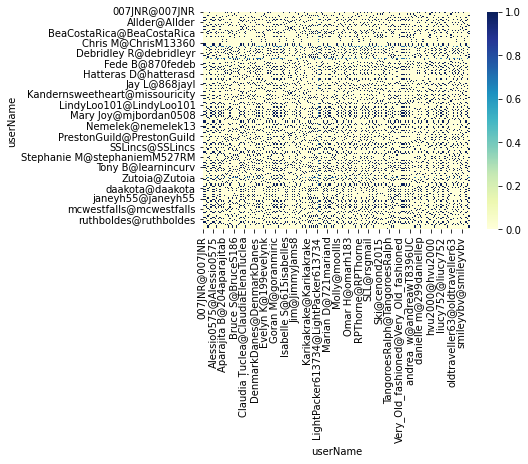

In [45]:
sns.heatmap(userName_userName_sim_matrix, cmap='YlGnBu')
plt.show()


In [46]:
# Check the matrix results
userName_userName_sim_matrix.head()

userName,007JNR@007JNR,101ramirez@101ramirez,1039@1039,112HermanK@112HermanK,1171fc@1171fc,123susan456@123susan456,1247912@1247912,14DLB@14DLB,1527holiday1011@1527holiday1011,159terencej@159terencej,...,ynwafoodie@ynwafoodie,yrf2016@yrf2016,zaxmo@zaxmo,zoeh198@zoeh198,zuv@zuv,Μάρθα Μ@_T6960IQ,Екатерина Г@_C5261QZ,Иван@ivanishchenko,Катарина П@reddreamer,Рамиль Х@ramilk2013
userName,,,,,,,,,,,,,,,,,,,,,
007JNR@007JNR,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.000000,...,1.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.000000,0.0,0.0
101ramirez@101ramirez,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.000000,...,1.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.000000,0.0,0.0
1039@1039,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,...,0.0,0.707107,0.707107,0.0,0.0,0.0,0.0,0.707107,0.0,0.0
112HermanK@112HermanK,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.000000,...,1.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.000000,0.0,0.0
1171fc@1171fc,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [47]:
# Similar customers
userName_userName_sim_matrix.loc['112HermanK@112HermanK'].sort_values(ascending=False)

userName
007JNR@007JNR              1.0
Louis A@169louisa          1.0
MJL1965@MJL1965            1.0
M P@MPrasetyo              1.0
Lynda K@898lyndak          1.0
                          ... 
Biblioswiss@Biblioswiss    0.0
Lynn C@lynndyloowho        0.0
Lynn G@lynng439            0.0
Lynn J@lynnj977            0.0
Рамиль Х@ramilk2013        0.0
Name: 112HermanK@112HermanK, Length: 4084, dtype: float64

In [48]:
# Check locals visited by tripType A
nonZeroLocals = (NameattuserNameMatrix.loc['112HermanK@112HermanK'] !=0)
userNameA_ranked_for_Nameatt = set(NameattuserNameMatrix.columns[nonZeroLocals])
userNameA_ranked_for_Nameatt

{'Historic Centre of Brugge'}

In [49]:
# Check locals visited by tripType B
nonZeroLocals = (NameattuserNameMatrix.loc['1171fc@1171fc'] !=0)
userNameB_ranked_for_Nameatt = set(NameattuserNameMatrix.columns[nonZeroLocals])
userNameB_ranked_for_Nameatt

{'Church of the Savior on Spilled Blood'}

In [50]:
# Local to recommend to tripType B
userNameB_ranked_for_Nameatt = userNameA_ranked_for_Nameatt - userNameB_ranked_for_Nameatt
userNameB_ranked_for_Nameatt

{'Historic Centre of Brugge'}

## Based on Attraction Name Similarity

In [51]:
# Similiar Attraction Name matrix
Nameatt_Nameatt_sim_matrix = pd.DataFrame(
    pairwise_distances(NameattuserNameMatrix.T,metric='cosine'),
    columns = NameattuserNameMatrix.columns,
    index = NameattuserNameMatrix.columns
    )
Nameatt_Nameatt_sim_matrix = Nameatt_Nameatt_sim_matrix.apply(lambda x: 1-x, axis=1) # Transform dissimilarity to similarity
Nameatt_Nameatt_sim_matrix

Name,Acueduct of Segovia,Ancient City of Ephesus,Basilica Papale e Sacro Convento...,Church of the Savior on Spilled Blood,Historic Areas of Istanbul,Historic Centre of Brugge,Mezquita Cathedral de Cordoba,Place Stanislas,Quinta da Regaleira,Sassi di Matera
Name,,,,,,,,,,
Acueduct of Segovia,1.000000,0.000000,0.000000,0.002542,0.004195,0.002284,0.026477,0.000000,0.002638,0.004765
Ancient City of Ephesus,0.000000,1.000000,0.005172,0.010464,0.017267,0.000000,0.003353,0.000000,0.002172,0.003923
Basilica Papale e Sacro Convento...,0.000000,0.005172,1.000000,0.000000,0.012966,0.003530,0.000000,0.000000,0.000000,0.014729
Church of the Savior on Spilled Blood,0.002542,0.010464,0.000000,1.000000,0.007870,0.005714,0.003821,0.000000,0.003300,0.000000
Historic Areas of Istanbul,0.004195,0.017267,0.012966,0.007870,1.000000,0.007072,0.000000,0.000000,0.000000,0.004918
Historic Centre of Brugge,0.002284,0.000000,0.003530,0.005714,0.007072,1.000000,0.010301,0.004665,0.001483,0.000000
Mezquita Cathedral de Cordoba,0.026477,0.003353,0.000000,0.003821,0.000000,0.010301,1.000000,0.000000,0.003966,0.007163
Place Stanislas,0.000000,0.000000,0.000000,0.000000,0.000000,0.004665,0.000000,1.000000,0.000000,0.009731
Quinta da Regaleira,0.002638,0.002172,0.000000,0.003300,0.000000,0.001483,0.003966,0.000000,1.000000,0.003093


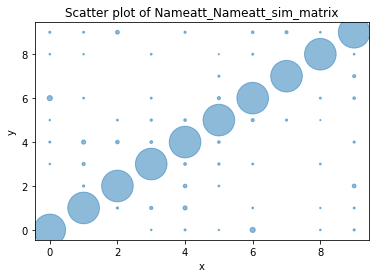

In [52]:
x = Nameatt_Nameatt_sim_matrix.columns
y = Nameatt_Nameatt_sim_matrix.index

x,y = np.meshgrid(range(Nameatt_Nameatt_sim_matrix.shape[1]), range(Nameatt_Nameatt_sim_matrix.shape[0]))
plt.scatter(x,y, s=Nameatt_Nameatt_sim_matrix.values*1000, alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter plot of Nameatt_Nameatt_sim_matrix')
plt.show()

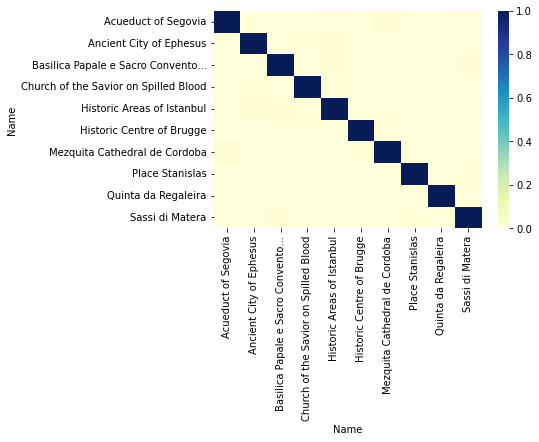

In [53]:
sns.heatmap(Nameatt_Nameatt_sim_matrix, cmap='YlGnBu')
plt.show()

In [54]:
# Top 3 attractions similar to 'Acueduct of Segovia '
top_3_similar_attractions = list(
    Nameatt_Nameatt_sim_matrix
        .loc['Acueduct of Segovia']
        .sort_values(ascending=False)
        .iloc[1:4]         # 1 to 4 instead of 0 to 10 because the first is the product itself
    .index
)
top_3_similar_attractions

['Mezquita Cathedral de Cordoba',
 'Sassi di Matera',
 'Historic Areas of Istanbul']